### Work on part 2

In this project, the goal of the Ultimate managers is to encourage drivers to spend their time in both cities, not just one or the other. We want a metric that will tell us if drivers are spending their time in both cities. This metric should rate poorly if the drivers spend all their time in one city, and highly if they are equally dividing their time between the two cities.

We will begin assuming that all rides begin in one of the two cities. Then we can easily get a metric, G_rides, which is the percent of all rides that begin (passenger is picked up) in Ultimate Gotham. I chose Ultimate Gotham for this bit, but either city could be used - the math is the same.

We will then calculate a new metric, Equality, calculated using G_rides. Equality = (100% - 2*abs(G_rides - 50%)). 

Equality reflects the distribution of how drivers spend their time between the cities. If all of a drivers' rides begin in Ultimate Gotham, G_rides = 100% and Equality = 0%. Likewise, if all of a drivers' rides begin in Ultimate Metropolis, G_rides = 0% and Equality = 0%. If rides between the two cities are equally balanced, G_rides = 50% and Equality = 100%.

I like Equality because the value of Equality is intuitive after being calculated. A low Equality is bad, a high Equality is good, and there is a straightforward linear relationship that governs Equality.

As a practical experiment, I would offer occasional promotions that give full reimpursements to drivers for toll fares. This promotion would occasionally be phased in and out, which would allow me to compare the value of Equality during multiple separate time phases. That way I can avoid having my data thrown off by special events that may drive up interest in cross-city traffic in only one time period, and give greater statistical robustness to my analysis.

For example. I might offer this toll reimbursement on alternating weeks so that I can compare the values of Equality with and without the promotion. Once the data is collected, I can calculate the value of Equality for every driver who drove during this period. Assuming some large number of drivers were active during multiple periods, I can then track changes in the value of Equality with and without the promotions among this group of drivers. I can conduct significance tests to find the confidence interval that my promotion is successfully increasing Equality as well as the average increase in Equality when the promotion is active.

I would interpret my results by seeing whether there is a statistically significant increase in the value of Equality during the period when the promotion is active, as well as quantifying the change. by multiplying the average driver's increase Equality by the average number of rides during the promotion period, I can get a measurement of how many additional rides were started in their opposite city because of the promotion.

Example: (Equality increases by 20%) * (15 average rides) = 3 additional rides started in their less-commonly-visited city.

In addition, it would be important to track the total amount of available drivers, the average number of rides started per driver and the average amount of revenue earned per driver during this experiment. While the goal of this experiment is technically not to make a profit, it would be rather self-defeating to create a promotion that succeeds in increasing the equality of rides between cities but also loses money overall on reimbursing toll costs, or that somehow diminishes availability by reducing the number of available drivers overall.

### Work on part 3 of the Ultimate Challenge

In [1]:
# import the data

import pandas as pd
import numpy as np

import json
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
df = pd.DataFrame(data)

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


##### It seems that there are missing values in the avg_rating_of_driver, phone and avg_rating_by_driver columns. Also the date columns are not formatted as datetime. Let's fix that.

In [3]:
# We can fill the average ratings sections by using the median values of these columns.

df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)

# Here we convert two categories to datetime values.

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [4]:
print(df['phone'].value_counts())


iPhone     34582
Android    15022
Name: phone, dtype: int64


##### iPhones are more common than Android phones in this dataset. We are missing the 'phone' variable for about 400 entries or ~0.8% of our data. 

In [5]:
# Fill phone data with a placeholder variable.
df['phone'] = df['phone'].fillna('other')

df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


##### Now we have dealt with all of our null values.

In [6]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.650038,1.074764,8.849536,60.926084,5.796827,4.779050
std,3.792684,0.575601,0.222336,19.958811,37.081503,5.707357,0.445974
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


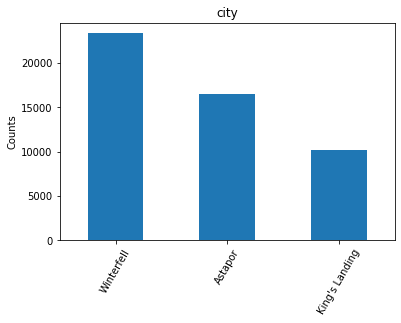

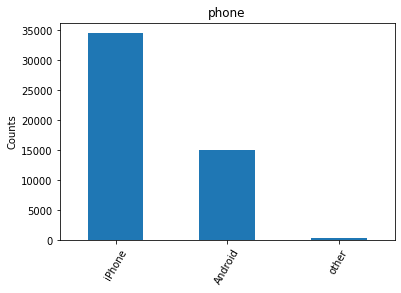

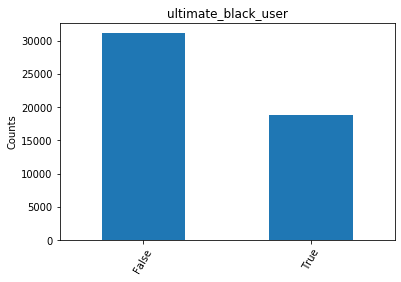

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot categorical features
for feature in ['city', 'phone', 'ultimate_black_user']:
    ax = df[feature].value_counts().plot(kind='bar')
 
    plt.xticks(rotation=60)
    plt.ylabel('Counts')
    plt.title(feature)
    plt.show()

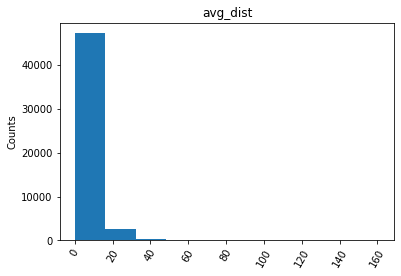

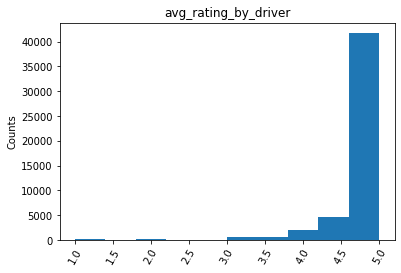

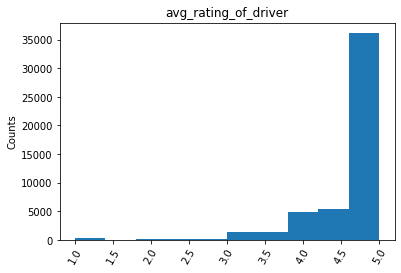

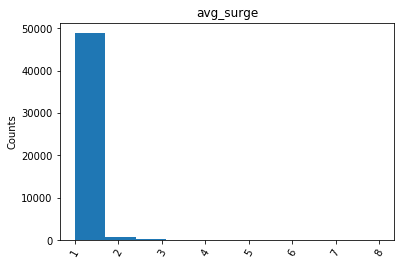

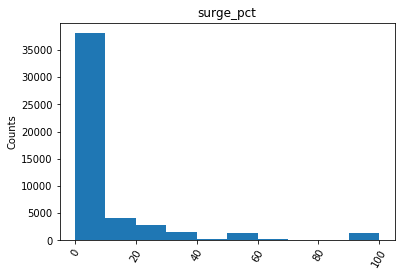

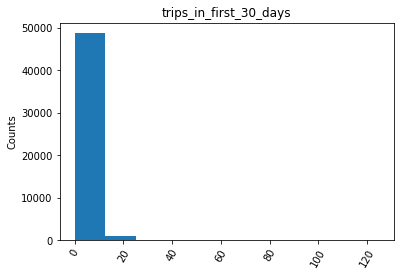

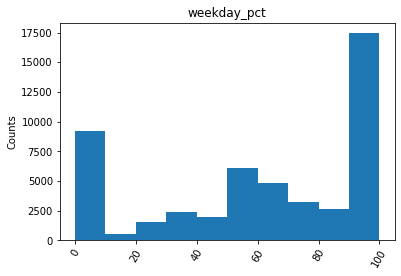

In [8]:
# Plot numerical features
for feature in ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
                'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']:
    ax = df[feature].plot(kind='hist')
 
    plt.xticks(rotation=60)
    plt.ylabel('Counts')
    plt.title(feature)
    plt.show()

##### Most of these plots show heavy skew, suggesting outliers. Let's look at box plots to examine this.

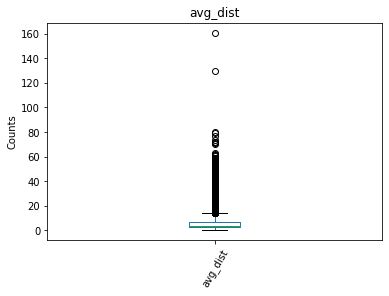

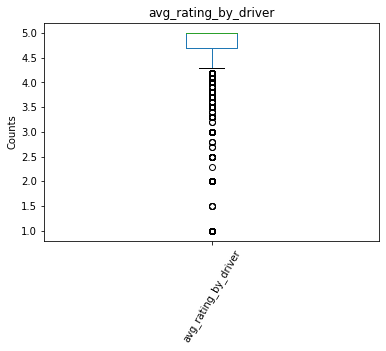

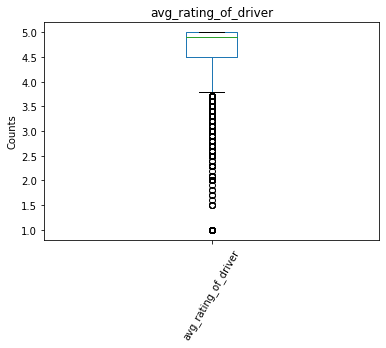

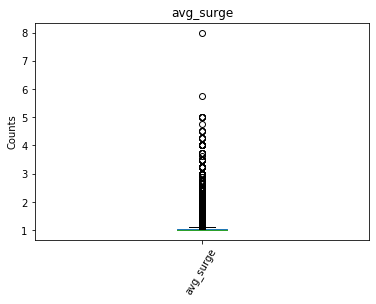

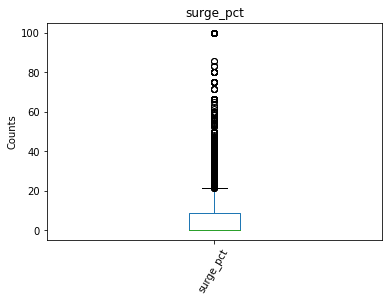

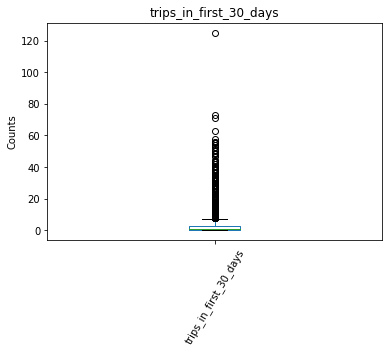

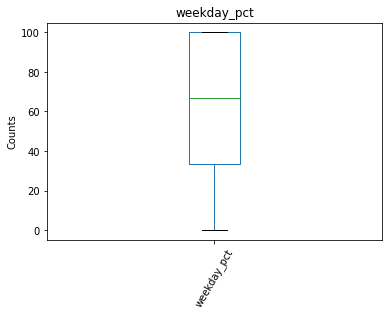

In [9]:
# Make box plots of categorical features
for feature in ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
                'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']:
    ax = df[feature].plot(kind='box')
 
    plt.xticks(rotation=60)
    plt.ylabel('Counts')
    plt.title(feature)
    plt.show()

In [10]:
##### Some of these features seem to have strong outliers - the most egregious is surge pricing.

##### Now let's add a new feature that identifies active accounts. A user is considered 'retained' if they took a ride within the last 30 days.

In [11]:
df['last_trip_date'].sort_values().tail()

45126   2014-07-01
38651   2014-07-01
14473   2014-07-01
22735   2014-07-01
45357   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

##### The last trip date is 2014-07-01, so we are looking at accounts with rides that take place on or after 2014-06-01.

In [12]:
# Create a boolean variable. True if last_trip_date is on or after '2014-06-01'

df['active_account'] = (df['last_trip_date'] >= ('2014-06-01'))

In [13]:
df.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_account
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [14]:
frac_active = np.sum(df['active_account'])/len(df) * 100

print(str(frac_active) + "% of the observed users were retained.")

37.608000000000004% of the observed users were retained.


#### It looks like 37.6% of users are retained.

### Part 3.2

##### Now we want to make a machine learning model to predict user retention. We need to modify our active_account variable because this problem asks for the user retention after 6 months, not the user retention overall. We need to throw out accounts younger than 6 months, then check at the 6-month marker.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
active_account            50000 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.3+ MB


##### Now let's take our features and clean them with scaling and onehot encoding.

In [16]:
# Scale numeric features
numerical_features = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge','surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_scaled= pd.DataFrame(scaler.fit_transform(numerical_features),columns=numerical_features.columns)

print(numerical_scaled.head(5))

# Convert categories to ints
categorical_features = pd.get_dummies(df[['city','phone','ultimate_black_user','active_account']])

# Convert bools to ints
categorical_features['ultimate_black_user'] = categorical_features['ultimate_black_user'].astype(int)
categorical_features['active_account'] = categorical_features['active_account'].astype(int)

print(categorical_features.head(5))

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  surge_pct  \
0 -0.372650              0.495437              0.086801   0.113506   0.328202   
1  0.431583              0.495437              0.608000  -0.336268  -0.443394   
2 -0.880771              0.495437             -0.608132  -0.336268  -0.443394   
3 -0.602181              0.271207             -0.086933   0.293416   0.558679   
4 -0.467266              0.271207             -0.434399   0.518303   0.147829   

   trips_in_first_30_days  weekday_pct  
0                0.453984    -0.397131  
1               -0.600689    -0.294653  
2                0.190316     1.053741  
3                1.772325     0.514383  
4                3.090665     0.579106  
   ultimate_black_user  active_account  city_Astapor  city_King's Landing  \
0                    1               1             0                    1   
1                    0               0             1                    0   
2                    0              

In [17]:
### Now we merge our two feature sets. This meghod leaves out the timestamp data, which we don't need.

model_data = pd.concat([numerical_scaled, categorical_features], axis=1)

In [18]:
model_data.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user,active_account,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,-0.372650,0.495437,0.086801,0.113506,0.328202,0.453984,-0.397131,1,1,0,1,0,0,1,0
1,0.431583,0.495437,0.608000,-0.336268,-0.443394,-0.600689,-0.294653,0,0,1,0,0,1,0,0
2,-0.880771,0.495437,-0.608132,-0.336268,-0.443394,0.190316,1.053741,0,0,1,0,0,0,1,0
3,-0.602181,0.271207,-0.086933,0.293416,0.558679,1.772325,0.514383,1,1,0,1,0,0,1,0
4,-0.467266,0.271207,-0.434399,0.518303,0.147829,3.090665,0.579106,0,0,0,0,1,1,0,0


In [19]:
### Perform a train-test split on this dataset

model_features =  list(model_data.columns)

model_features.remove('active_account')

X = model_data[model_features]
y = model_data['active_account']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=555)
print(X_train.shape)

(40000, 14)


##### Now that we have cleaned data ready for training, we need to make a model. I will be using a random forest classifier as it is known for high accuracy but is also easily interpretable - we can quickly get feature importances to understand what our model is doing.

##### There are several other approaches that could be taken here. Logistic Regression models also offer accuracy and interpretability, but usually do not do quite as well. We could try a neural network approach which might give higher accuracy at the cost of interpretability - this is fine if we aren't trying to necessarily understand our results, but in this case we do. Random forests offer reasonable accuracy and are easily understandable, which is ideal for this use case.

In [20]:
### Here I will use a grid search to find a random forest model with the best parameters on the training set

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

param = {'n_estimators': [5, 10, 20, 50],
         'max_depth': [5, 10, 20, 50] }

### I use 5-fold cross-validation to get the accuracy of the models

gs=GridSearchCV(rf, param, cv=5, n_jobs=5)

gs_fit = gs.fit(X_train, y_train)

pd.DataFrame(gs_fit.cv_results_).sort_values(by=['rank_test_score']).head(5)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.736400,0.005608,0.058402,0.005922,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.783000,0.785500,0.782625,0.779250,0.781625,0.782400,0.002027,1
6,0.361503,0.022187,0.017598,0.001199,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.780875,0.785250,0.780375,0.777250,0.779375,0.780625,0.002626,2
5,0.184197,0.012185,0.020800,0.015262,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.780375,0.783750,0.775500,0.778125,0.779000,0.779350,0.002715,3
4,0.086086,0.002646,0.007111,0.001118,10,5,"{'max_depth': 10, 'n_estimators': 5}",0.776625,0.780000,0.779000,0.771875,0.774000,0.776300,0.003032,4
3,0.483200,0.004447,0.028598,0.002575,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.769250,0.777875,0.768875,0.769750,0.770250,0.771200,0.003370,5


##### It looks like the best model manages 78.2% accuracy on the training set. Now let's examine these results.

In [21]:
### accuracy on test set

best_rf = gs_fit.best_estimator_
preds = best_rf.predict(X_test)
probs = pd.DataFrame(best_rf.predict_proba(X_test)).iloc[:,0]

best_rf.score(X_test,y_test) * 100

78.42

##### Our test accuracy is 78.7%. Not bad - slightly higher than the training accuracy. Underfit?


Text(0.5, 1.0, 'ROC Curve')

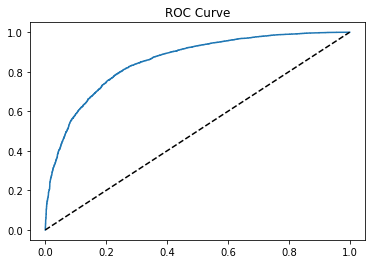

In [22]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
plt.plot(tpr,fpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')


In [23]:
##### The ROC curve looks reasonable. Check confusion matrix - are the FP and TP rates reasonable?

In [24]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)

,0,1
0,5340,846
1,1312,2502


In [25]:
##### This also seems fine. Now let's look at feature importances. What can we learn from the model?

Feature ranking:
1. feature 1 : (avg_dist) (0.183060)
2. feature 6 : (avg_rating_by_driver) (0.129103)
3. feature 4 : (avg_rating_of_driver) (0.122288)
4. feature 9 : (avg_surge) (0.116422)
5. feature 3 : (surge_pct) (0.079112)
6. feature 5 : (trips_in_first_30_days) (0.072846)
7. feature 7 : (weekday_pct) (0.060326)
8. feature 0 : (ultimate_black_user) (0.056433)
9. feature 12 : (city_Astapor) (0.046847)
10. feature 11 : (city_King's Landing) (0.046461)
11. feature 2 : (city_Winterfell) (0.035214)
12. feature 8 : (phone_Android) (0.031859)
13. feature 10 : (phone_iPhone) (0.018694)
14. feature 13 : (phone_other) (0.001334)


<Figure size 432x288 with 0 Axes>

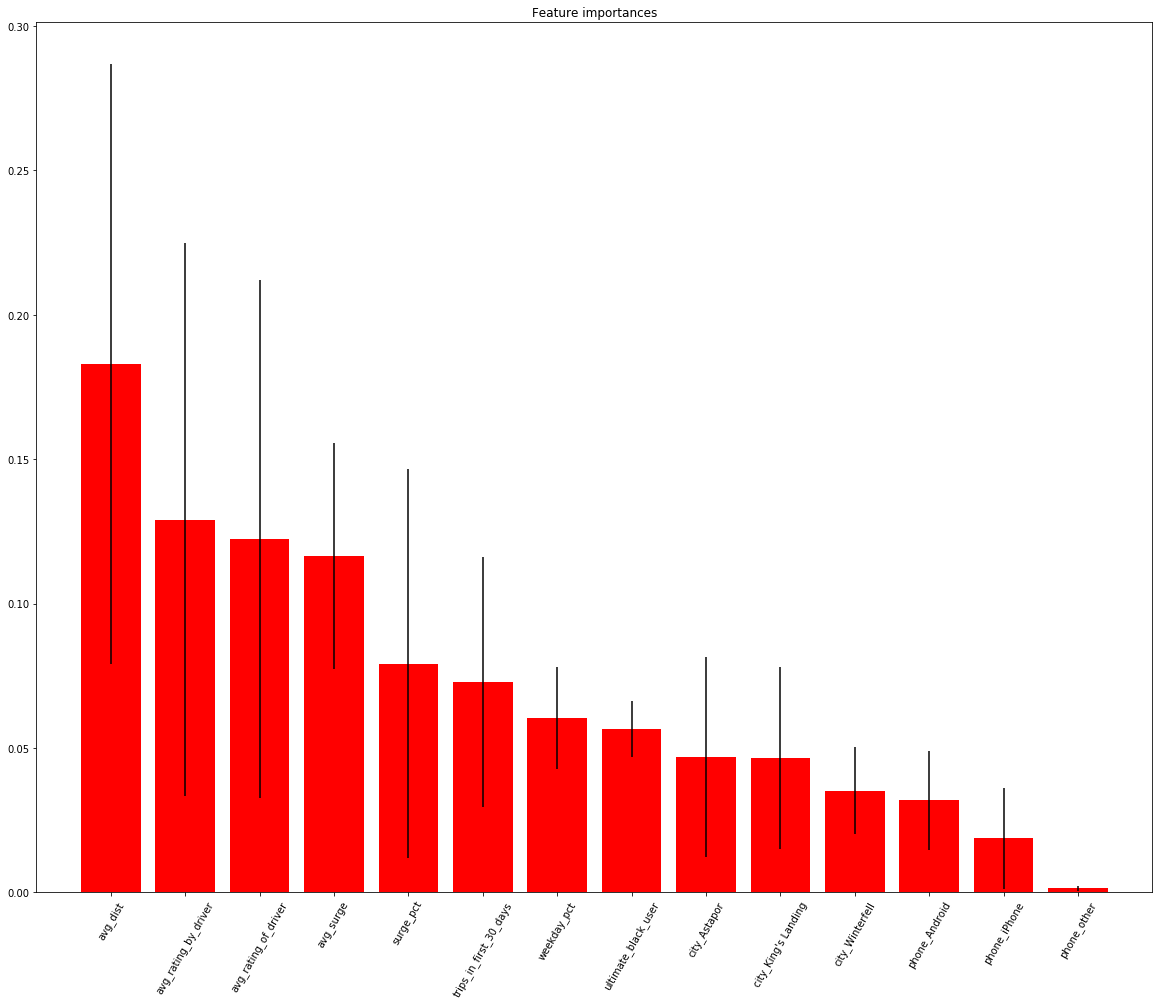

In [26]:
import matplotlib.pyplot as plt

importances = gs_fit.best_estimator_.feature_importances_

std = np.std([tree.feature_importances_ for tree in gs_fit.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")


for f in range(X[model_features].shape[1]):
    print("%d. feature %d : (%s) (%f)" % (f + 1, indices[f], model_features[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
plt.figure()
plt.figure(figsize=(20,16))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title("Feature importances")
plt.bar(range(X[model_features].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X[model_features].shape[1]), model_features)
plt.xticks(rotation=60)
plt.xlim([-1, X[model_features].shape[1]])
plt.savefig('graphs/Feature_importances_of_Random_Forest.png')
plt.show()

##### The most important features are avg_dist, avg_rating_by_driver and avg_rating_of_Driver, although there are wide error bars on all of these feature importances. Let's look at these variables for retained and non-retained riders.

In [27]:
retained_df = df[ df['active_account'] == True]
unretained_df = df[ df['active_account'] == False ]

In [28]:
retained_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000
mean,3.306318,4.619581,1.073809,9.152797,61.389034,5.114788,4.763226
std,4.986743,0.525474,0.163170,15.588704,29.487584,4.615175,0.328339
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.400000,1.000000,0.000000,44.400000,2.560000,4.700000
50%,2.000000,4.900000,1.000000,0.000000,64.300000,3.730000,4.800000
75%,4.000000,5.000000,1.090000,13.300000,84.600000,5.890000,5.000000
max,125.000000,5.000000,4.500000,100.000000,100.000000,160.960000,5.000000


In [29]:
unretained_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000
mean,1.658482,4.668397,1.075339,8.666739,60.647032,6.207939,4.788588
std,2.654222,0.603075,0.251361,22.179139,40.982688,6.238675,0.503548
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,16.700000,2.320000,4.800000
50%,1.000000,4.900000,1.000000,0.000000,69.600000,4.030000,5.000000
75%,2.000000,5.000000,1.000000,0.000000,100.000000,7.800000,5.000000
max,73.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### Recommendations

##### It seems that retained users took slightly shorter trips, and gave and received very slightly lower rating, than unretained drivers. This suggests that it is better to market the use of Ultimate for shorter rather than longer trips, but there is not a huge absolute change in these variables.

##### More informatively, we see that the magnitude of a surge, taking a trip in the first 30 days, using Ultimate Black, and taking trips on weekends are all strong predictors of retention. These are more easily turned into actionable suggestions. I would suggest to the marketing team that they take actions to encourage new users to take trips soon after signing up, such as with signup discounts or free trips. Furthermore it could be useful to market specific weekend promotions or Ultimate Black promotions to boost use of that service.

